## Autoregression Approach

THe autoregression model is following exactly the same approach as the linear regression, except that we'll add the lag of the prediction column as an additional feature.

In [1]:
# import the needed libs
import numpy as np # For different array operations
import pandas as pd # For dealing with CSV files and creating DataFrames
import matplotlib.pyplot as plt # For plotting the graphs
from sklearn.model_selection import train_test_split # For splitting the data
from sklearn.metrics import mean_squared_error  # Loss funcitons

df = pd.read_csv('../Traffic Data Applied Linear Algebra.csv') # Reading the raw csv file
df = df.sort_values(by=["Season", "DayOfWeek", "Period"], ascending=True)
df = df.reset_index(drop=True)

# Here I'm generating the t-1 column, in our case it's Arrivals - 1
df = pd.concat([df[['Arrivals']].shift(1), df], axis=1)
df.columns = ["Arrivals - 1", "Season", "DayOfWeek", "Period", "PricePerGB", "Arrivals", "Departures"]
df = df.dropna()

# Preparing the datafor forcasting
features = ["Season", "DayOfWeek", "Period", "PricePerGB", "Arrivals - 1"]
target = ["Arrivals"]

X = df[features]
Y = df[target]

train_X, test_X, train_Y, tset_Y = train_test_split(X, Y, test_size=0.2, shuffle=False)

Here is the core of the model, calculating the Pseudo-Inverse and getting fitted coefficients.

In [2]:
X_pinv = np.linalg.pinv(train_X)
coefficients = np.dot(X_pinv, train_Y)
print(coefficients)

[[ 5.07339128]
 [ 2.26881321]
 [ 0.41909662]
 [-7.314665  ]
 [ 0.6096535 ]]


Now use the coefficients to compute the dot product with the test split to obtain the predicted values $\hat{y}$ ($A x = \hat{y}$) -> $A$ is the split set values and $x$ is the coefficients we calculated above.

In [3]:
pred_Y = np.dot(test_X, coefficients)
print(pred_Y.flatten()[:5])

[39.3499957  39.71334827 48.24967421 45.23821262 51.94440109]


Calculate the next 100 days inputs

In [4]:
last_row = tset_Y.iloc[-1]
last_Y = int(last_row["Arrivals"])

next_season = 1
number_of_periods_per_day = 24
number_of_next_periods = 100
i = 0
day_of_week = 0
day_of_week_arr = []
periods_arr = []

while i < number_of_next_periods:
    day_of_week = (day_of_week + 1) % 7
    for period in range(1 ,number_of_periods_per_day+1):
        day_of_week_arr.append(day_of_week)
        periods_arr.append(period)
        i = i + 1
        if i >= 100:
            break



# 4. Random PricePerGB (1 or 2)
Season = [next_season for i in range(100)]
price_per_gb = np.random.choice([1, 2], size=number_of_next_periods)

# Build df
next_100_days_df = pd.DataFrame({
    "Season": Season,
    "DayOfWeek": day_of_week_arr,
    "Period": periods_arr,
    "PricePerGB": price_per_gb,
    "Arrivals - 1": 0
}).sort_values(by=["DayOfWeek", "Period"], ascending=True)

next_100_days_df.head()

,Season,DayOfWeek,Period,PricePerGB,Arrivals - 1
0,1,1,1,2,0
1,1,1,2,1,0
2,1,1,3,1,0
3,1,1,4,2,0
4,1,1,5,1,0


Now let's predict the next 100 days, but Instead of generatign the whole result just once like the linear regression, here we need to iterate and calculte it one by one, to get the value of the prev lag value (t-1)

In [9]:
next_100_days_df.loc[0, "Arrivals - 1"] = last_Y
next_100_days_Y = []

# Instead of generatign the whole results just once like the linear regression, here we need to iterate and calculte it one by one,
# to get the value of the prev lag value (t-1)
for idx, row in next_100_days_df.iterrows():
    next_Y = np.dot(row, coefficients)[0]
    next_100_days_Y.append(next_Y)
    if idx > 0:
        next_100_days_df.loc[idx+1, "Arrivals - 1"] = next_Y

# print(next_100_days_Y[:5])

Plotting all the data

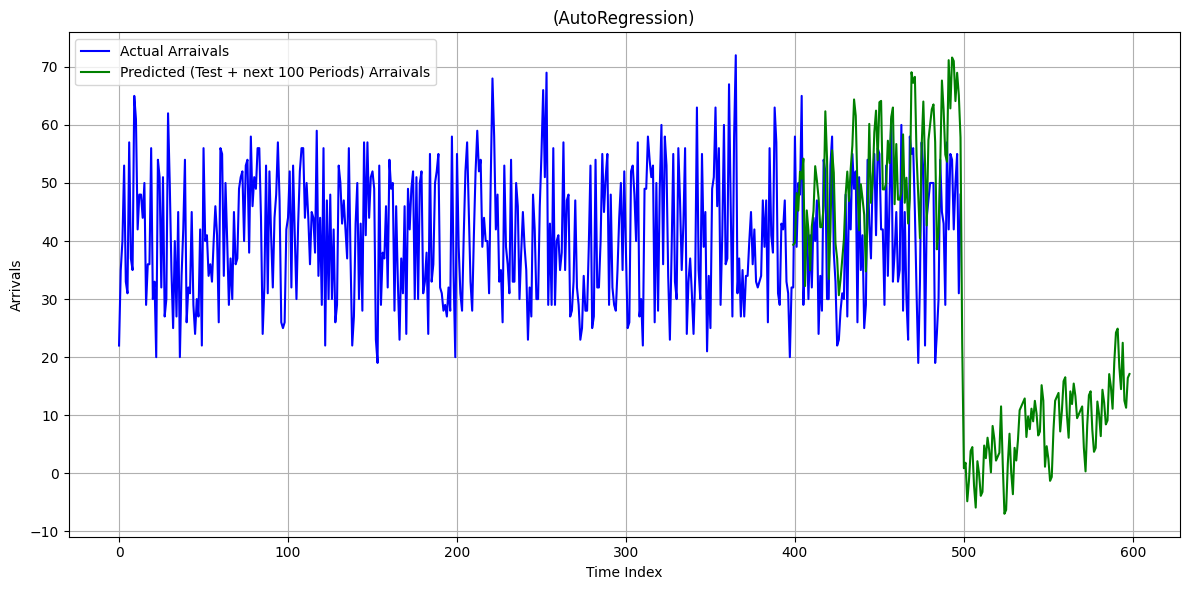

In [10]:
all_actual_data = np.concatenate((train_Y.values, tset_Y.values))
all_predicted = np.concatenate((pred_Y.flatten(), next_100_days_Y))

# Create a continuous time axis
actual_data_index = np.arange(len(all_actual_data))
predected_data_index = np.arange(len(train_Y), len(train_Y) + len(all_predicted))

plt.figure(figsize=(12, 6))

# --- Plot sections ---

# 1. Plot all actual
plt.plot(actual_data_index, all_actual_data, label="Actual Arraivals", color="blue")

# 3. Plot predictions on top of test
plt.plot(predected_data_index, all_predicted, label="Predicted (Test + next 100 Periods) Arraivals", color="green")

# Labels, title, etc.
plt.title("(AutoRegression)")
plt.xlabel("Time Index")
plt.ylabel("Arrivals")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

Plot only the test part to see our predictions accuracy

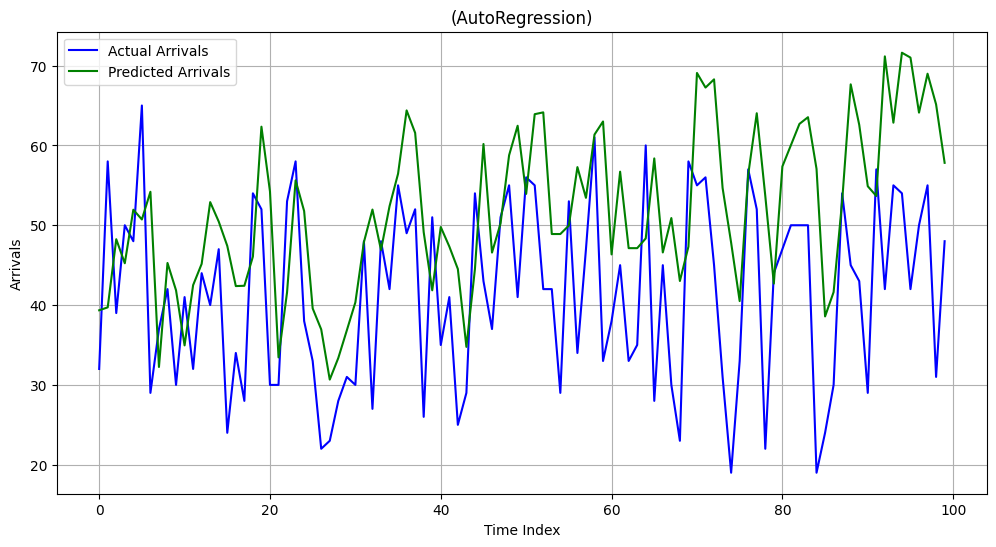

In [11]:
actual = tset_Y.values.flatten()
predicted = pred_Y.flatten()

plt.figure(figsize=(12, 6))

# Plot actual values
plt.plot(actual, label="Actual Arrivals", color="blue")

# Plot predicted values
plt.plot(predicted, label="Predicted Arrivals", color='green')

plt.title("(AutoRegression)")
plt.xlabel("Time Index")
plt.ylabel("Arrivals")
plt.legend()
plt.grid(True)
plt.show()

In [12]:
# Convert to flat arrays
y_true = tset_Y.values.flatten()
y_pred_flat = pred_Y.flatten()

# --- Error metrics ---
mse = mean_squared_error(y_true, y_pred_flat)
rmse = np.sqrt(mse)

# --- Print ---
print("Model Evaluation:")
print(f"RMSE (Root Mean Squared Error): {rmse:.4f}")


Model Evaluation:
RMSE (Root Mean Squared Error): 15.4137
